# Tutorial
Here is a notebook containing my first experiences with Keras, the tutorial I used can be found [here](https://elitedatascience.com/keras-tutorial-deep-learning-in-python), and a general course on deep learning can be found [here](https://cs231n.github.io/).
This Notebook will contain general steps that I can use in future projects
## Step 1: Importing Modules
First we are going to import numpy (we set the seed for the sake of reproducibility)

In [1]:
import numpy as np
np.random.seed(123)

Next we are going to import our model (in this case we are using a Sequential model (i.e. a model that is just a stack of layers))

In [2]:
from keras.models import Sequential

Now we are going to import all of the models that we are going to use for this model

In [3]:
from keras.layers import Dense, SpatialDropout2D, Dropout, Activation, Flatten # Common in all Neural Networks
from keras.layers import Convolution2D, MaxPooling2D # Convolutional layers used for efficient training on images

Finally we will import some utility functions from Keras

In [4]:
from keras.utils import np_utils
from keras.metrics import AUC

## Step 2: Load (Image) data
We will now import our dataset, we are using the MNIST dataset (provided as a part of keras)

In [5]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
print(X_train.shape)

(60000, 28, 28)


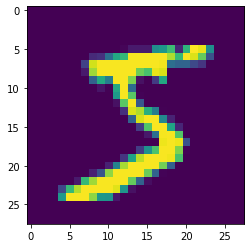

In [7]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

## Step 3: Preprocessing data for KERAS

### Preprocessing inputs

We will want to later use convolution as the first layer of our model, so we need to reshape our data into a form that can be input into the convolution. To do this we must put our data into the shape

(# of images, width, height, image depth)

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

We can easily check the dimension of the input shape by printing its shape

In [9]:
print(X_train.shape)

(60000, 28, 28, 1)


Finally we're going to normalise all the data so that instead of integers in \[0, 255\], they are floats in \[0, 1\]

In [10]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

### Preprocessing Class Labels

Now we are are going to look at the responses, lets look at the shape of our data

In [11]:
print(y_train.shape)

(60000,)


Lets look at the format of this data

In [12]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


We see that the data isn't in the required form, i.e. each element should be a binary vector with length corresponding to number of categories. To get it into this form we will now use the utility function provided by keras `np_utils.to_categorical`,

In [13]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

We can look at the new shape of this data to see

In [14]:
print(Y_train.shape)

(60000, 10)


and looking at the first 10 again we see that it is now in the requisite form

In [15]:
print(Y_train[:10,:])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Step 4: Define Model Architecture

We will now define the model architecture. In a general project this will be the step that will take the longest, but as this is a tutorial, we already have one which are going to implement, this model will be a [sequential model](https://keras.io/guides/sequential_model/). (This model is in fact an example of a ConvNet architecture, discussed [here](https://cs231n.github.io/convolutional-networks).

In [16]:
model = Sequential()

The first layer of our model will be a convolution layer, which we add below

In [17]:
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))

To explain all of the parameters:
 - `input_shape` tells the layer the shape of a single sample
 - `activation` tells us the activation function
 - `32` represents the number of filters outputted
 - `(3, 3)` represents the size of the kernel used

We can check the output shape of the model by doing the following

In [18]:
print(model.output_shape)

(None, 26, 26, 32)


We can now add more layers to the model, using
 - `MaxPooling2D`
  - This will be used to reduce the dimension of our image by choosing max pixel within the pool size
 - `SpatialDropout2D`
  - This is a layer used for regularisation in order to make sure the model generalises decently (We could just use a regular `Dropout` layer, but `SpatialDropout2D` takes advantage of the fact we are using spatial data) (A list of other regularisation layers can be found [here](https://keras.io/api/layers/regularization_layers/) and list of layer weight regularisation methods can be found [here](https://keras.io/api/layers/regularizers/)

In [19]:
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(0.25, data_format='channels_last'))
print(model.output_shape)

(None, 12, 12, 32)


We can see that the size of the output has been significantly reduced (mainly thanks to `MaxPooling2D`), so we will now go to a flattened perspective on the data to finish off the ConvNet, again using a `Dropout` layer as a means of regularisation.

In [20]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(10, activation='softmax'))

Note that the activation function `softmax` is used specifically for the case where we want to classify an object into one of $n \geq 2$ categories, so the $i^\text{th}$ output represents the probability that the input is a member of the $i^\text{th}$ category. (A list of activation functions used in keras can be found [here](https://keras.io/api/layers/activations/))
## Step 5: Compile Model

Here is where we tell our model what it is trying to opimise (the loss function we are going to use), how to do it (i.e. the optimiser to use), and metrics we may want to measure. Within the documentation many [loss functions](https://keras.io/api/losses/), [optimisers](https://keras.io/api/optimizers/), and [metrics](https://keras.io/api/metrics/) are given.

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', AUC(multi_label = False)])

## Step 6: Fit Model on training

Training the model is simple once the model is set up, we just need to supply the data as well as some extra parameters:
 - `batch_size` says how many samples to use for each gradient calculation
 - `epochs` says the number of times to go through the training data provided
 - `verbose` says whether we want the information on the progress of the training to be printed or not
You can find out more about training Models in Keras [here](https://keras.io/api/models/model_training_apis/#fit-method). Callbacks can be used during training for a variety of things, as shown [here](https://keras.io/api/callbacks/).

In [22]:
model.fit(X_train, Y_train, 
          batch_size=16, epochs=10, verbose=1)

Epoch 1/10
3750/3750 [==============================] - 8s 2ms/step - loss: 1.0023 - accuracy: 0.6161 - auc: 0.9427
Epoch 2/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.7106 - accuracy: 0.7151 - auc: 0.9708
Epoch 3/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.6540 - accuracy: 0.7332 - auc: 0.9750
Epoch 4/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.6093 - accuracy: 0.7482 - auc: 0.9782
Epoch 5/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.5942 - accuracy: 0.7578 - auc: 0.9792
Epoch 6/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.5757 - accuracy: 0.7632 - auc: 0.9803
Epoch 7/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.5534 - accuracy: 0.7738 - auc: 0.9817
Epoch 8/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.5370 - accuracy: 0.7815 - auc: 0.9828
Epoch 9/10
3750/3750 [==============================] - 8s 2ms/step - lo

## Step 7: Evaluate Model

Here is where we look at the metrics and decide whether or not the model we have created is good enough, documentation can be found [here](https://keras.io/api/models/model_training_apis/#evaluate-method).

The value for loss indicates the value of the loss function calculated for the test data, and accuracy represents the (approximate) probability that the model will predict the category the input comes from accurately.

For an explanation of AUC (i.e a metric used to measure how well a model can differentiate between classes), look [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5), [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/), and [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). For a brief explanation, we basically plot FPR (False Positive Rate) against TPR (True Positive Rate and find the AUC (Area Under Curve). To plot FPR against TPR, we consider what would occur if we set $p$ as our threshold probability, i.e. if probability in $i^\text{th}$ category $<p$ then assume input not in $i^\text{th}$ else, it is in the $i^\text{th}$ category. THE AUC can be intepretted as 
$$ \mathbb{P}\left(X_1 > X_0\right) $$
where $X_1$ is the score for a positive piece of data and $X_0$ is the score for a negative piece (proof shown [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Further_interpretations)).

In [23]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("AUC: " + str(score[2]))

Loss: 0.05212957039475441
Accuracy: 0.9851999878883362
AUC: 0.9991110563278198


## Outside the Box

Now we're outside the scope of the tutorial and I'm gonna run a bit wild, we're going to explore one of the utility functions, specifically `plot_model`, which can be found [here](https://keras.io/api/utils/model_plotting_utils/#plot_model-function).

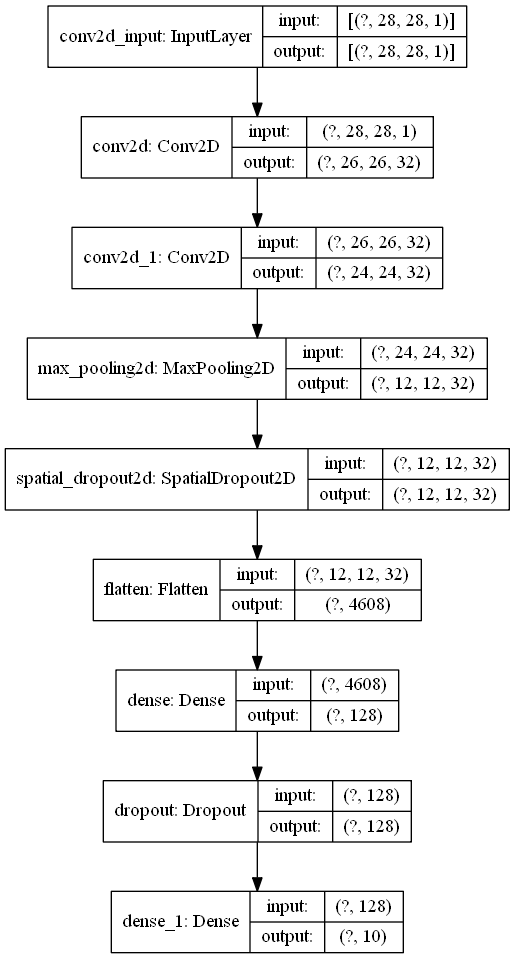

In [24]:
from keras.utils import plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Layers of the onion

We're going to use the function `get_layer` (details [here](https://keras.io/api/models/model/#getlayer-method)) to try and see the filters that the model creates for the data provided.
jk, we're going to use the method described [here](https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction). 

You can run the code below as many times as you like, each time generating the filters for different inputs:

The number written was: 1


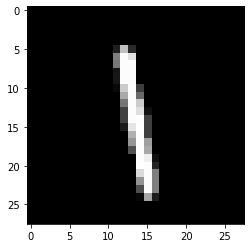

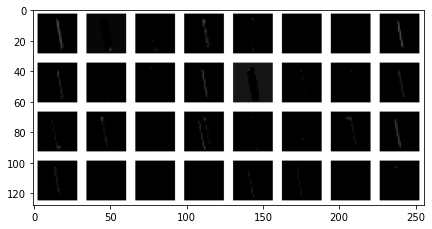

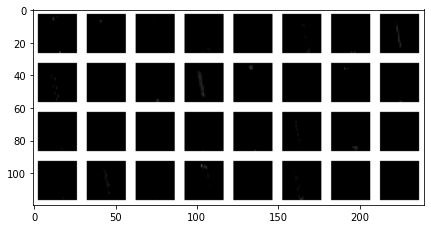

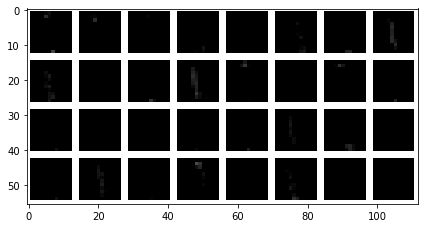

In [25]:
from keras import Model
from numpy import ones, argmax
from numpy.random import randint

extractor = Model(inputs=model.inputs,
                  outputs=[layer.output for layer in model.layers])

index = randint(0,X_test.shape[0])
print("The number written was: {}".format(argmax(Y_test[index:])))
data = X_test[index,:,:,:].reshape(1,28,28,1)
features = extractor(data)

pad = 3
picture1 = ones(((26+2*pad)*4,(26+2*pad)*8))

for i in range(4):
    for j in range(8):
        num = 8 * i + j
        picture1[(i * (26 + 2 * pad) + pad): (i * (26 + 2 * pad) + 26 + pad), 
                 (j * (26 + 2 * pad) + pad): (j * (26 + 2 * pad) + 26 + pad)] = features[0].numpy()[0,:,:,num]

picture2 = ones(((24+2*pad)*4,(24+2*pad)*8))

for i in range(4):
    for j in range(8):
        num = 8 * i + j
        picture2[(i * (24 + 2 * pad) + pad): (i * (24 + 2 *pad) + 24 + pad), 
                 (j * (24 + 2 * pad) + pad): (j * (24 + 2 *pad) + 24 + pad)] = features[1].numpy()[0,:,:,num]

pad=1
picture3 = ones(((12+2*pad)*4,(12+2*pad)*8))

for i in range(4):
    for j in range(8):
        num = 8 * i + j
        picture3[(i * (12 + 2 * pad) + pad): (i * (12 + 2 * pad) + 12 + pad), 
                 (j * (12 + 2 * pad) + pad): (j * (12 + 2 * pad) + 12 + pad)] = features[2].numpy()[0,:,:,num]
        
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(X_test[index,:,:,:].reshape(28,28), cmap='gray')
plt.figure(figsize=(7, 6))
plt.imshow(picture1, cmap='gray')
plt.figure(figsize=(7, 6))
plt.imshow(picture2, cmap='gray')
plt.figure(figsize=(7, 6))
plt.imshow(picture3, cmap='gray')